In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score

In [48]:
#Convert json file to DataFrame
df = pd.read_json("train.json")

# Exploratory Data Analysis

In [49]:
df.describe()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


In [50]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


#### Distribution of Cuisines

In [51]:
cuisines = df['cuisine'].value_counts() #Create a Series of cuisines with number of instances in the DataFrame

C:\Users\home\AppData\Local\Temp\ipykernel_21140\2038247357.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=cuisines.values,y=cuisines.index,palette="viridis")


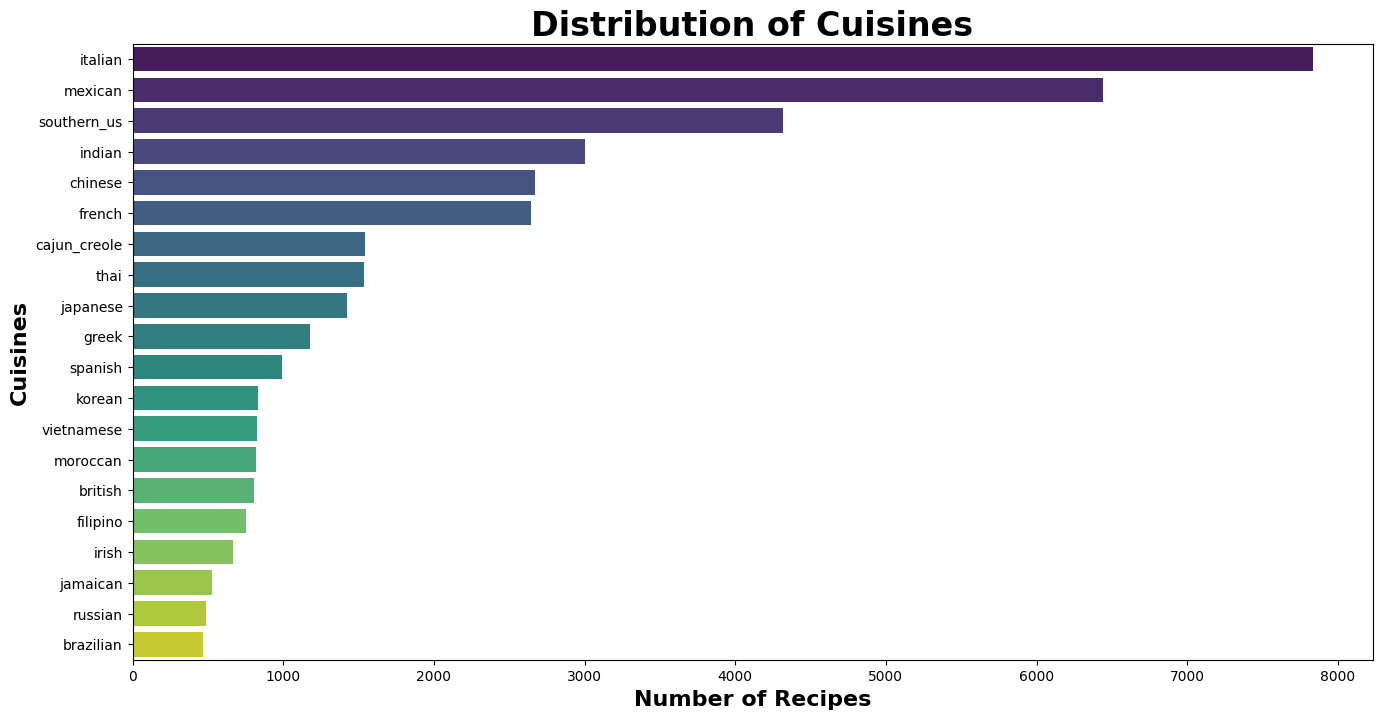

In [52]:
#Turn the cuisine count Series into a Bar Graph
plt.figure(figsize=(16,8))
sb.barplot(x=cuisines.values,y=cuisines.index,palette="viridis")
plt.title("Distribution of Cuisines", fontsize=24, fontweight="bold")
plt.xlabel("Number of Recipes", fontsize=16, fontweight="bold")
plt.ylabel("Cuisines", fontsize=16, fontweight="bold")
plt.show()


#### Most Common Ingredients

In [53]:
#Create a Series of instances of each ingredients, and get the most common 20
ingredient_list = df['ingredients'].explode()
sorted_ingredients = ingredient_list.value_counts()
sorted_ingredients = sorted_ingredients[:20]
common_ingredients = sorted_ingredients.index

C:\Users\home\AppData\Local\Temp\ipykernel_21140\3136166340.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=sorted_ingredients.values,y=sorted_ingredients.index,palette="viridis")


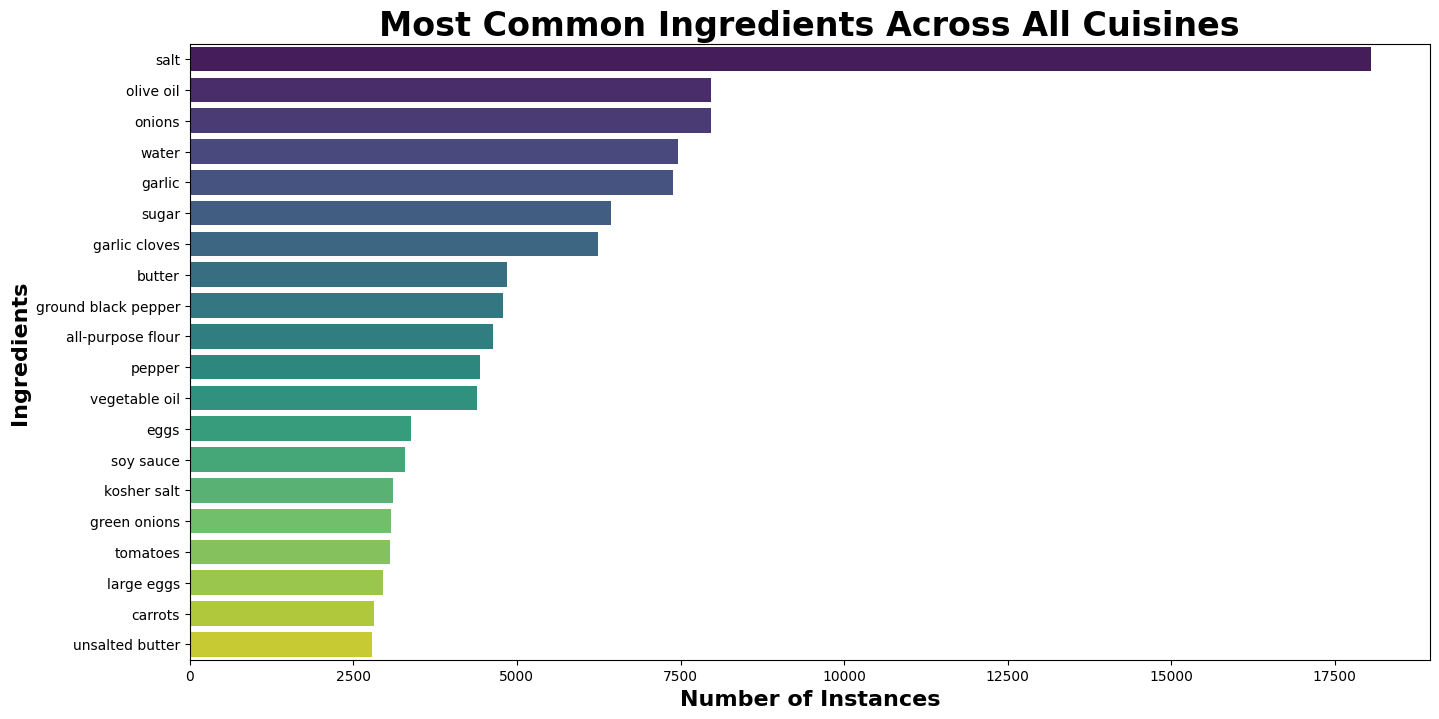

In [54]:
#Turn the ingredient count Series into a Bar Graph
plt.figure(figsize=(16,8))
sb.barplot(x=sorted_ingredients.values,y=sorted_ingredients.index,palette="viridis")
plt.title("Most Common Ingredients Across All Cuisines", fontsize=24, fontweight="bold")
plt.xlabel("Number of Instances", fontsize=16, fontweight="bold")
plt.ylabel("Ingredients", fontsize=16, fontweight="bold")
plt.show()

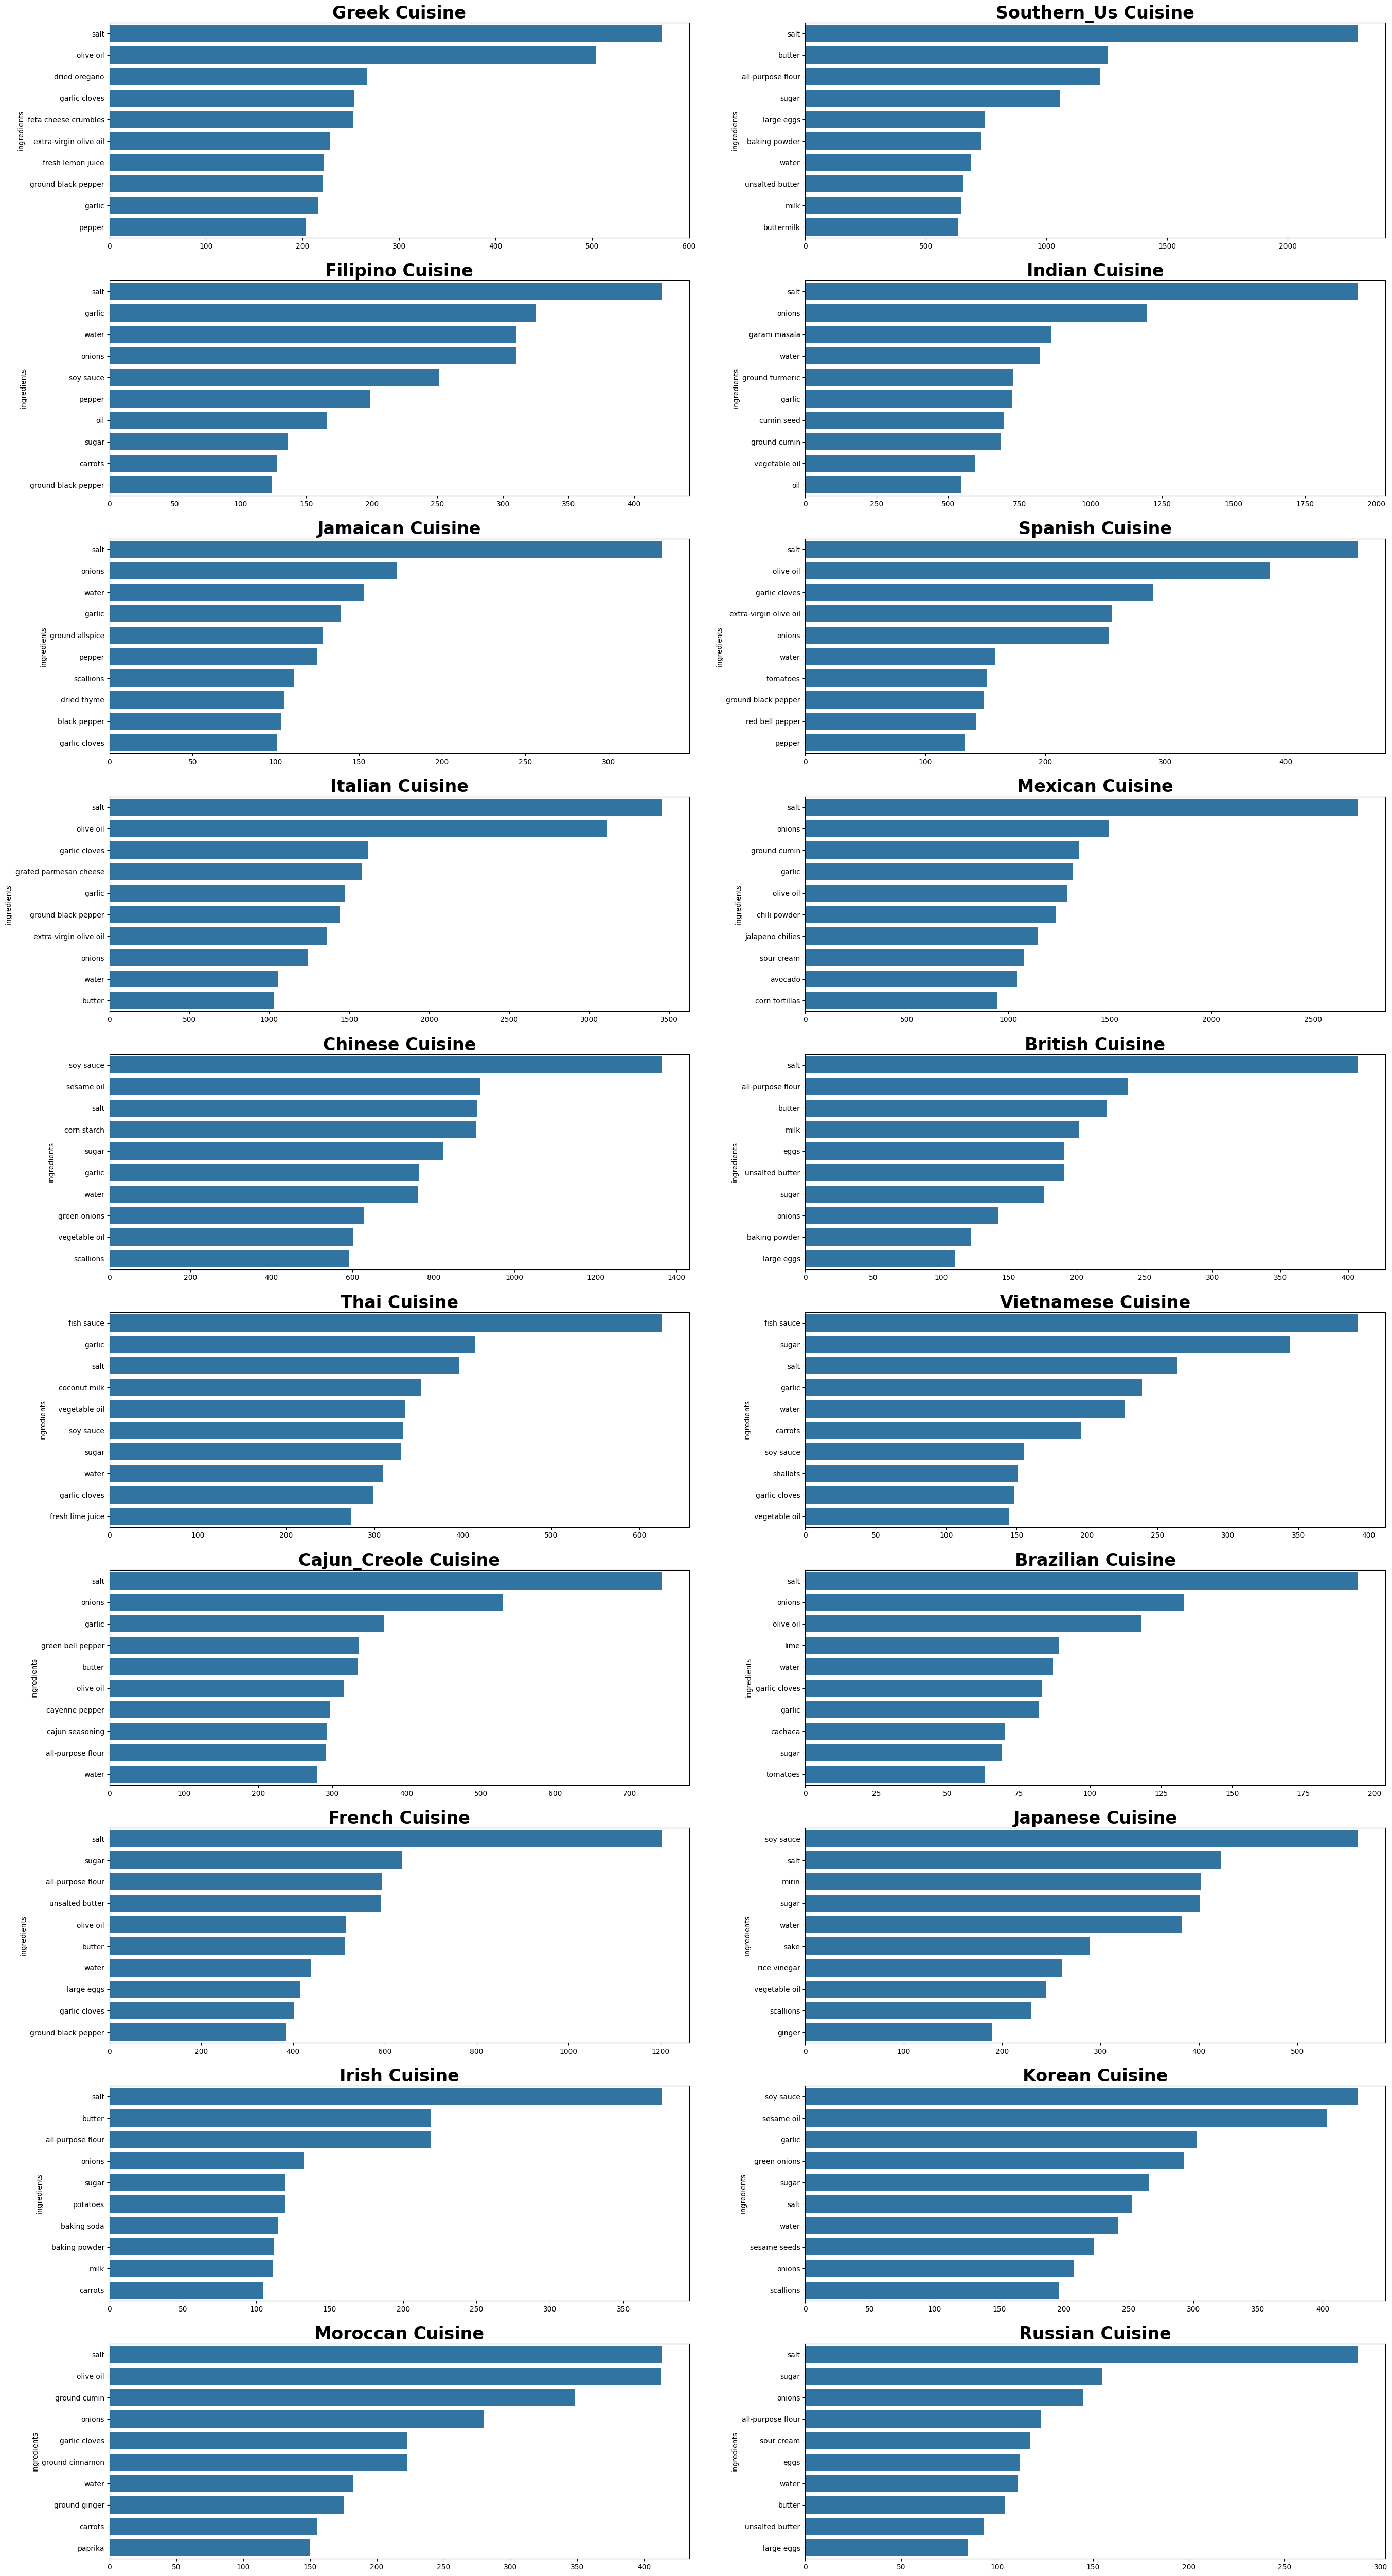

In [55]:
#Create a Series of instances of each ingredients for each cuisine, and get the most common 20
cuisine_ingredients = {}
for cuisine in df['cuisine'].unique():
    ingredient_list = df[df['cuisine']==cuisine]['ingredients'].explode()
    sorted_ingredients = ingredient_list.value_counts()
    sorted_ingredients = sorted_ingredients[:10]
    cuisine_ingredients[cuisine] = sorted_ingredients


#Turn each ingredient count Series into a Bar Graph for each cuisine
f, axes = plt.subplots((len(cuisines)+1)//2, 2, figsize=(32, 64))

count = 0
index = 0
for cuisine in cuisine_ingredients:
    ings = cuisine_ingredients[cuisine]
    plot = sb.barplot(x=ings.values,y=ings.index, ax = axes[count,index])
    plot.set_title(cuisine.title()+" Cuisine", fontsize=24, fontweight="bold")
    index += 1
    if index>1:
        index=0
        count += 1

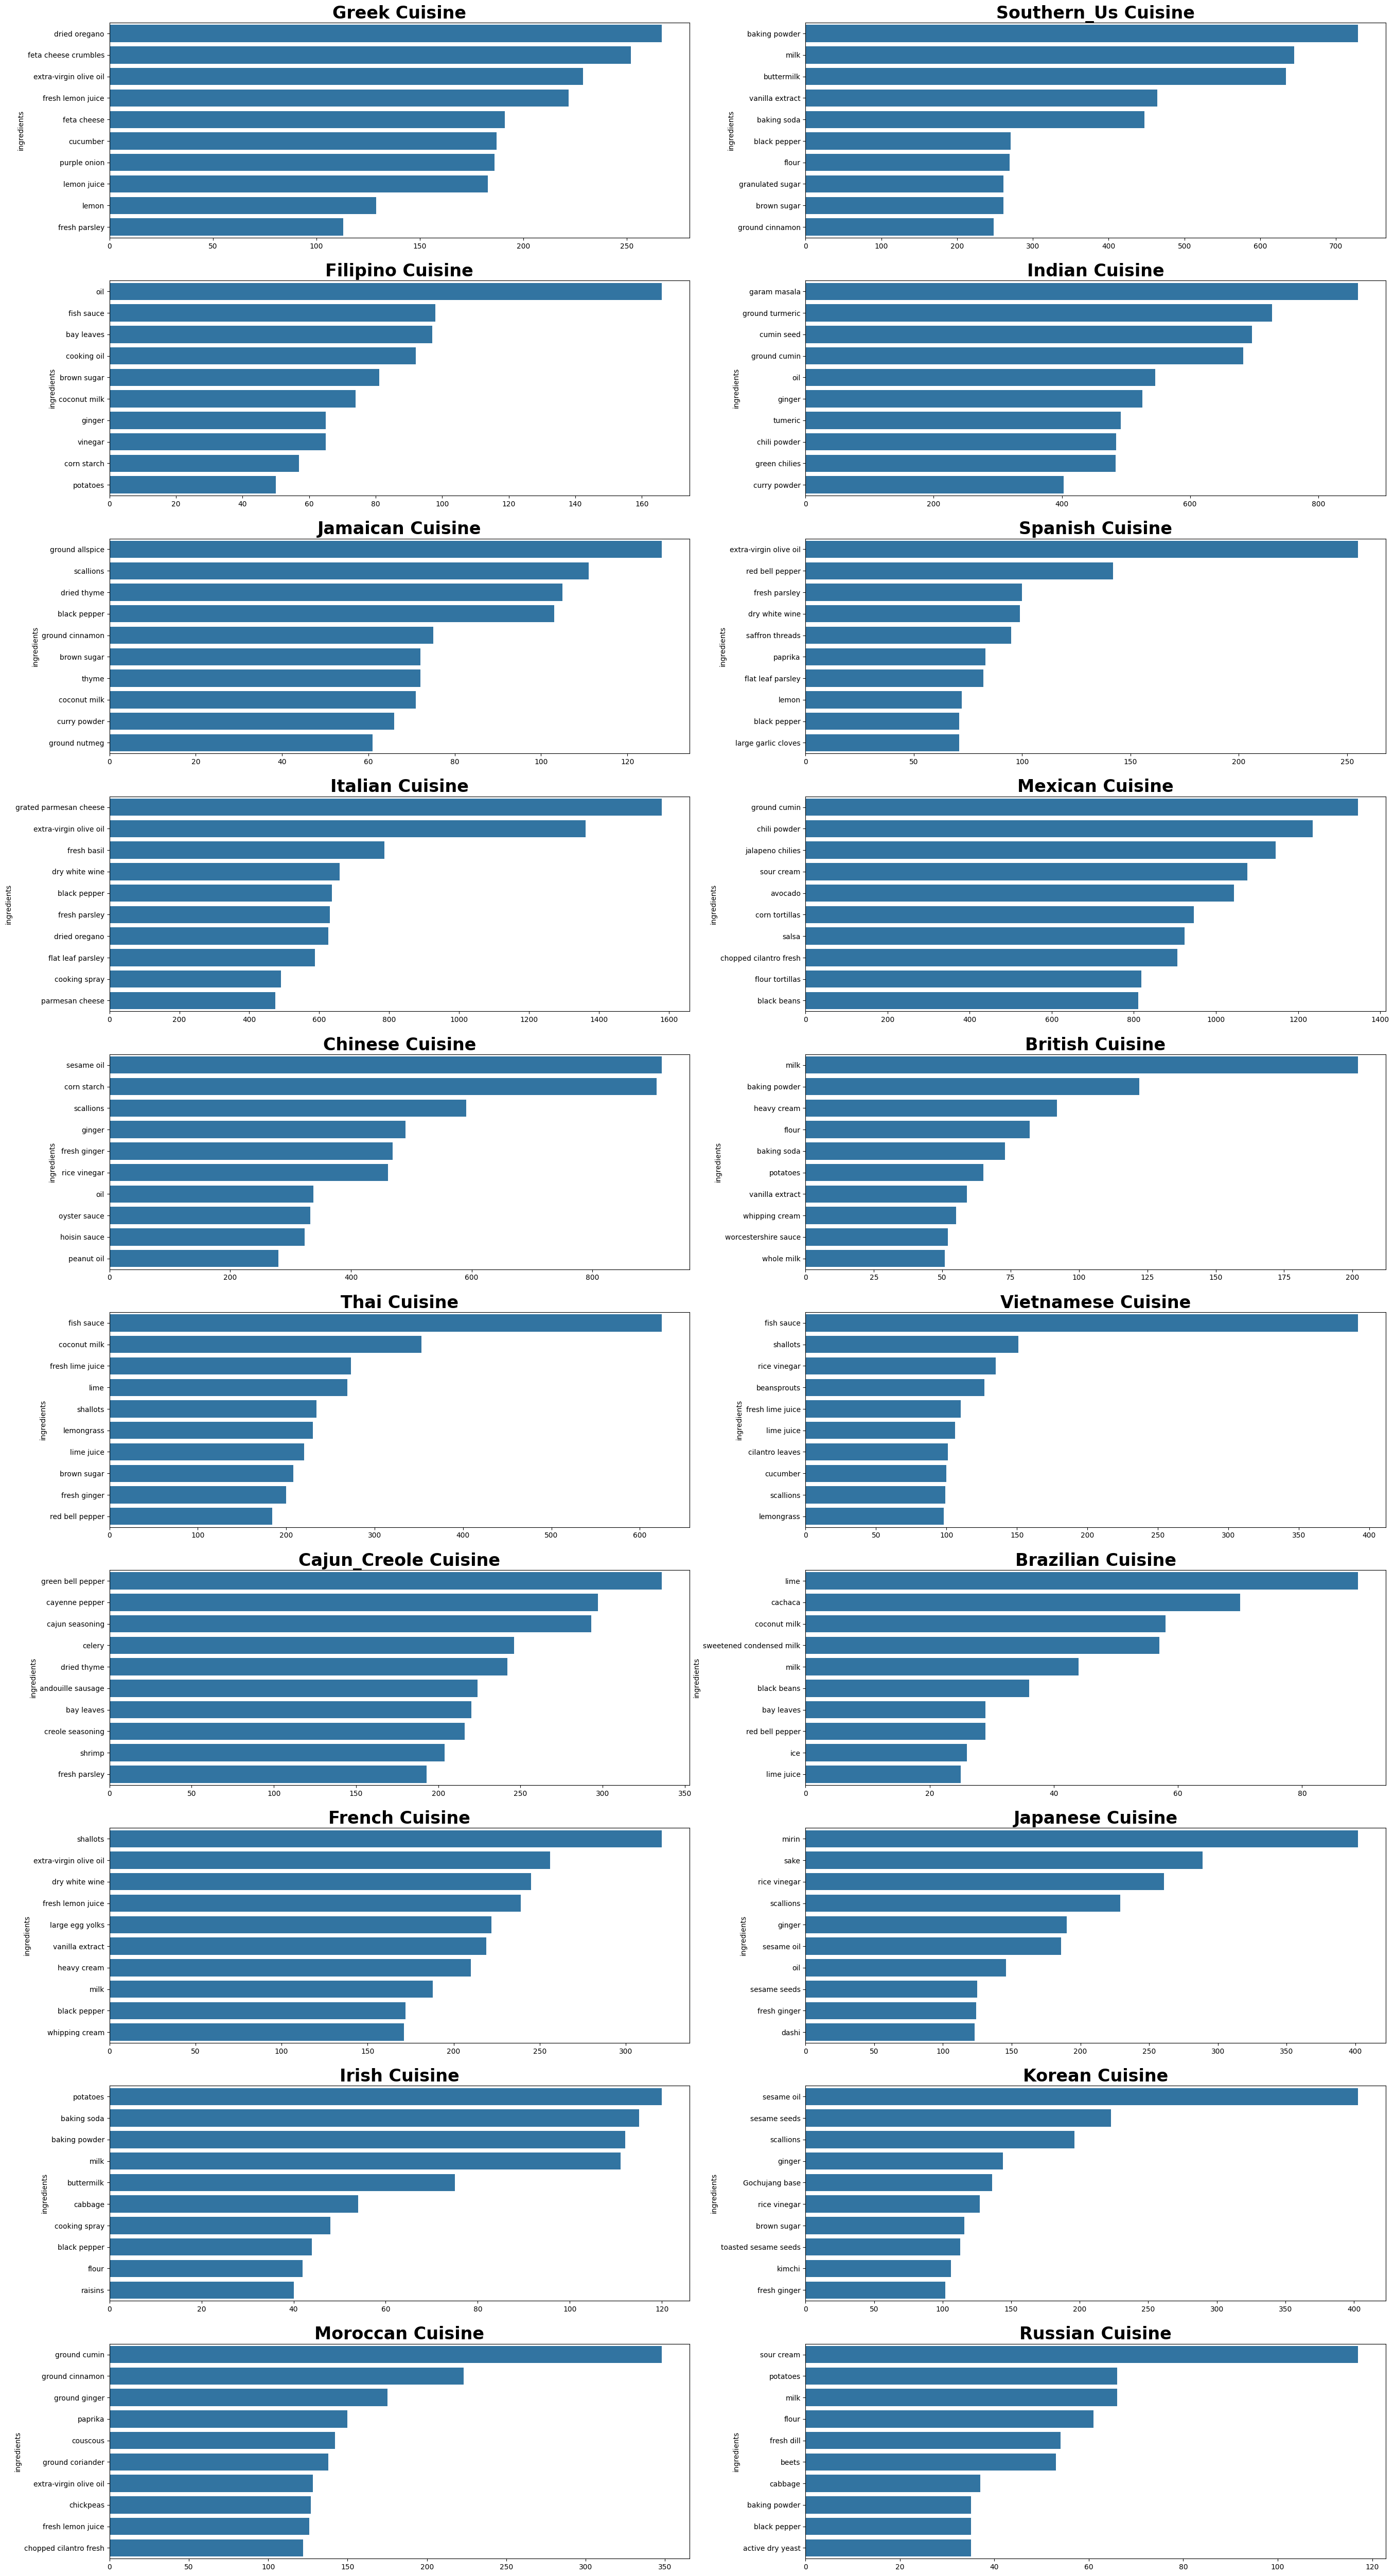

In [56]:
#Create a Series of instances of each ingredients for each cuisine, and get the most common 20
cuisine_ingredients = {}
for cuisine in df['cuisine'].unique():
    ingredient_list = df[df['cuisine']==cuisine]['ingredients'].explode()
    sorted_ingredients = ingredient_list.value_counts()
    for ing in common_ingredients: sorted_ingredients.pop(ing)
    sorted_ingredients = sorted_ingredients[:10]
    cuisine_ingredients[cuisine] = sorted_ingredients


#Turn each ingredient count Series into a Bar Graph for each cuisine
f, axes = plt.subplots((len(cuisines)+1)//2, 2, figsize=(32, 64))

count = 0
index = 0
for cuisine in cuisine_ingredients:
    ings = cuisine_ingredients[cuisine]
    plot = sb.barplot(x=ings.values,y=ings.index, ax = axes[count,index])
    plot.set_title(cuisine.title()+" Cuisine", fontsize=24, fontweight="bold")
    index += 1
    if index>1:
        index=0
        count += 1

# Data Processing

In [57]:
#Format ingredients to work in vectorization
def preprocess_df(df,common=False):
    
    def process_string(text):
        for i in range(len(text)):
            word = text[i]
            if common:
                if word in common_ingredients:
                    text[i]=''
                    continue
            #print(word,end='=>')
            word = re.sub(r'\(|\)', '', word) #Remove anything with brackets
            word = re.sub(r'[^\w]', '', word) #Remove special characters
            word = word.lower()
            text[i] = word
            #print(word)
        #print(text,end="=>")
        text = ' '.join(text)
        #print(text)
        return text
    
    df['ingredients'] = df['ingredients'].apply(process_string)
    
    return df

In [58]:
def get_cuisine_ingredients(df):
    cuisine_df = pd.DataFrame(columns=['ingredients'])
    for cus in df['cuisine'].unique():
        text = ""
        for x in df[df.cuisine == cus]['ingredients']:
            text += x
            text += " "
        cuisine_df.loc[cus,'ingredients'] = text

    cuisine_df = cuisine_df.reset_index()
    cuisine_df = cuisine_df.rename(columns ={'index':'cuisine'})
    return cuisine_df

In [59]:
X_train,X_test,Y_train,Y_test = train_test_split(pd.DataFrame(df['ingredients']),pd.DataFrame(df['cuisine']),train_size=0.1)
train = pd.concat([Y_train,X_train],axis=1)
test = pd.concat([Y_test,X_test],axis=1)
train_common = pd.concat([Y_train,X_train],axis=1)
test_common = pd.concat([Y_test,X_test],axis=1)

In [60]:
trainDF = preprocess_df(train)
testDF = preprocess_df(test)

trainDFcommon = preprocess_df(train_common,True)
testDFcommon = preprocess_df(test_common,True)

In [61]:
trainDF.head()

,cuisine,ingredients
26327,italian,freshbasil balsamicvinegar yellowonion crushed...
12733,chinese,tahini chilioil mincedgarlic sesameoil peanuto...
1794,mexican,buffalosauce crumbledbluecheese coarsekoshersa...
16820,british,unsaltedbutter anchovyfillets freshdill scotch...
34243,mexican,oliveoil garlic coriander lime vegetablebroth ...


In [62]:
train = trainDF['ingredients']
target = trainDF['cuisine']
test = testDF['ingredients']
test_target = testDF['cuisine']

train_common = trainDFcommon['ingredients']
test_common = testDFcommon['ingredients']

In [63]:
#Function to obtain normalized count from a string of ingredients
def tfidf_vectorizer(train, test=None):
    tfidf = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ),analyzer="word", 
                             max_df = .57 , binary=False , token_pattern=r'\w+' , sublinear_tf=False)
    train = tfidf.fit_transform(train)
    if test is None: return train,tfidf
    test = tfidf.transform(test)
    return train, test, tfidf

In [64]:
train_tfidf, test_tfidf, tfidf = tfidf_vectorizer(train,test)
train_tfidf_common, test_tfidf_common, tfidf_common = tfidf_vectorizer(train_common,test_common)

In [65]:
train_tfidf

<3977x3175 sparse matrix of type '<class 'numpy.float64'>'
	with 42962 stored elements in Compressed Sparse Row format>

# Modeling

In [66]:
param_grid = {'C': [i*0.1 for i in range(1,100)],  
              'penalty': ['l1','l2'],
             'loss': ['hinge','squared hinge']} 

grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')
grid_common = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3, n_jobs=-1, scoring='f1_micro')

In [67]:
grid.fit(train_tfidf,target)
grid_common.fit(train_tfidf_common,target)


Fitting 5 folds for each of 396 candidates, totalling 1980 fits


c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
1485 fits failed out of a total of 1980.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
495 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\s

Fitting 5 folds for each of 396 candidates, totalling 1980 fits


c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
1485 fits failed out of a total of 1980.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
495 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\s

GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                               0.6000000000000001, 0.7000000000000001, 0.8, 0.9,
                               1.0, 1.1, 1.2000000000000002, 1.3,
                               1.4000000000000001, 1.5, 1.6, 1.7000000000000002,
                               1.8, 1.9000000000000001, 2.0, 2.1, 2.2,
                               2.3000000000000003, 2.4000000000000004, 2.5, 2.6,
                               2.7, 2.8000000000000003, 2.9000000000000004, 3.0, ...],
                         'loss': ['hinge', 'squared hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='f1_micro', verbose=3)

In [68]:
print(grid.best_params_)
print(grid.best_score_)
print(grid_common.best_params_)
print(grid_common.best_score_)

{'C': 1.2000000000000002, 'loss': 'hinge', 'penalty': 'l2'}
0.7110973104516292
{'C': 1.1, 'loss': 'hinge', 'penalty': 'l2'}
0.7050614708763945


In [73]:
clf = LinearSVC(C=1.2,loss='hinge',penalty='l2')
clf_common = LinearSVC(C=1.1,loss='hinge',penalty='l2')

In [74]:
clf.fit(train_tfidf,target)
clf_common.fit(train_tfidf,target)


c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\home\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1.1, loss='hinge')

In [76]:
print(clf.score(test_tfidf,test_target))
print(clf_common.score(test_tfidf,test_target))

0.7112607201720814
0.7103667905131715


In [72]:
#ingredient_list.to_csv('ingredients.csv',header=False,index=False)